In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Embedding, Flatten, SimpleRNN, Bidirectional, LSTM, GRU
from tensorflow.keras.models import Sequential
 
import nltk
 
nltk.download('wordnet') # Lemmatization
nltk.download('punkt') # Tokenization 
nltk.download('stopwords') # stopwords 
 
 
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv("/content/drive/MyDrive/food_review.csv")

In [3]:
df.shape

(40500, 3)

In [4]:
df.head()

,Unnamed: 0,Text,Score
0,0,I bought these from a large chain pet store. a...,1
1,1,"This soup is incredibly good! But honestly, I...",5
2,2,Our family loves these tasty and healthy sesam...,5
3,3,The local auto shop offers this free to it cus...,4
4,4,I brought 2 bottles. One I carry in my pocket...,5


In [5]:
df.drop(["Unnamed: 0"],axis = 1,inplace=True)

In [6]:
df.isnull().sum()

Text     0
Score    0
dtype: int64

Note that there is no point for keeping rows with different scores or sentiment for same review text. So I will keep only one instance and drop the rest of the duplicates.


In [7]:
dup = df[df.duplicated(subset=['Text'],keep=False)]
dup.shape

(6729, 2)

In [8]:
df = df[df['Score'] != 3]
df.shape

(32397, 2)

In [9]:
score = df['Score'].apply(lambda x: 1 if x > 3 else 0)
df['Score'] = score
df.head(3)

,Text,Score
0,I bought these from a large chain pet store. a...,0
1,"This soup is incredibly good! But honestly, I...",1
2,Our family loves these tasty and healthy sesam...,1


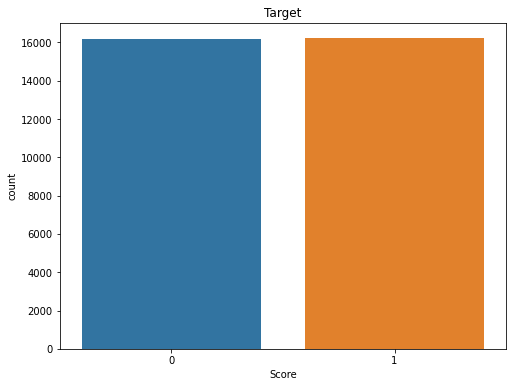

In [10]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.countplot(df['Score'])
plt.title('Target')
plt.show()

In [11]:
df['Score'].value_counts()

1    16223
0    16174
Name: Score, dtype: int64

In [12]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [13]:
from nltk.corpus import stopwords
stop_words= set(stopwords.words("english"))

In [14]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [15]:
import re
from bs4 import BeautifulSoup
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
df['Text'] = df['Text'].apply(lambda x: preprocess_text(x))

In [16]:
df['Text'].head()

0    buy large chain pet store read review check ba...
1    soup incredibly good honestly look better deal...
2    family love tasty healthy sesame honey almonds...
3    local auto shop offer free customers try twice...
4    bring bottle one carry pocket home fell love v...
Name: Text, dtype: object

Let us now print some Text and see if we can get insights from the text.

In [17]:
# printing some reviews to see insights.
for Text in df['Text'][:5]:
    print(Text+'\n'+'\n')

buy large chain pet store read review check bag make china throw whole bag away wish would read review first 


soup incredibly good honestly look better deal amazon free ship great buck get cheaper grocery store always wp sales buck anyone know better deal really good taste soup 


family love tasty healthy sesame honey almonds trader joe get crunchy flavor sesame seed combine subtle sweetness honey almond flavor wow great snack feel good eat favorite trader joe almond snack almonds good handful morning fruit smoothie snack lunch great way get protein healthy fat vitamin e almonds offer good idea measure cup almonds count almonds stay calorie range want keep within nutritionist recommend small amount almonds walnuts day good fat protein 


local auto shop offer free customers try twice like time perhaps pay might love price would still enjoy flavor 


bring bottle one carry pocket home fell love vacation belize couple drop trick pack ton flavor hot overpower food 




In [18]:
df.head()

,Text,Score
0,buy large chain pet store read review check ba...,0
1,soup incredibly good honestly look better deal...,1
2,family love tasty healthy sesame honey almonds...,1
3,local auto shop offer free customers try twice...,1
4,bring bottle one carry pocket home fell love v...,1


In [19]:
df['Score'].value_counts()

1    16223
0    16174
Name: Score, dtype: int64

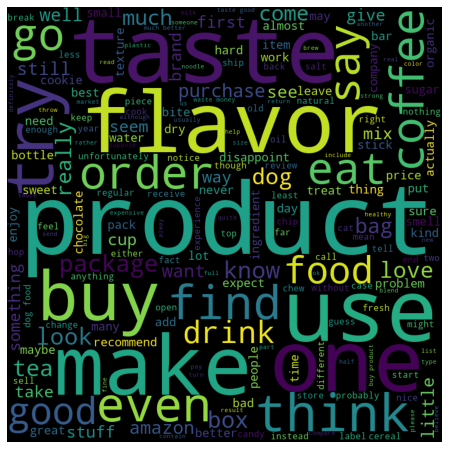

In [20]:
wc = WordCloud(width = 800, 
               height = 800, 
               background_color ='black',  
               min_font_size = 10)
 
wc.generate(''.join(df[df["Score"]==0]["Text"]))
 
plt.figure(figsize = (8,8)) 
plt.imshow(wc) 
plt.axis("off") 
plt.show()

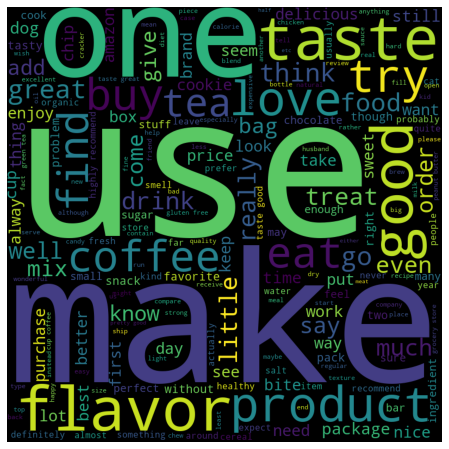

In [21]:
wc = WordCloud(width = 800, 
               height = 800, 
               background_color ='black',  
               min_font_size = 10)
 
wc.generate(''.join(df[df["Score"]==1]["Text"]))
 
plt.figure(figsize = (8,8)) 
plt.imshow(wc) 
plt.axis("off") 
plt.show()

In [22]:
X = df['Text']
y = df["Score"]

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

## Tokenization

In [24]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)

In [25]:
doc_length = []
for doc in train_sequences:
  doc_length.append(len(doc))

In [26]:
max(doc_length)

925

In [27]:
np.quantile(doc_length,0.99)

189.0

In [28]:
max_len = 112
train_padded = pad_sequences(train_sequences, maxlen=max_len)
print(train_padded)

[[  0   0   0 ...  88 979  74]
 [  0   0   0 ... 203  33   8]
 [  0   0   0 ... 354  32   3]
 ...
 [  0   0   0 ...  61 288  62]
 [  0   0   0 ... 206 175  60]
 [  0   0   0 ... 288  62  12]]


In [29]:
vocab_len = len(tokenizer.index_word)+1

In [30]:
# NN
model = Sequential()
model.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model.add(Flatten())
model.add(Dense(8, activation="tanh"))
model.add(Dense(1,activation="sigmoid"))

In [31]:
model.compile(loss="binary_crossentropy", optimizer="adam")

In [32]:
model.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 2s 5ms/step - loss: 0.5431
Epoch 2/50
260/260 [==============================] - 1s 5ms/step - loss: 0.2978
Epoch 3/50
260/260 [==============================] - 1s 5ms/step - loss: 0.2076
Epoch 4/50
260/260 [==============================] - 1s 5ms/step - loss: 0.1391
Epoch 5/50
260/260 [==============================] - 1s 5ms/step - loss: 0.0863
Epoch 6/50
260/260 [==============================] - 1s 5ms/step - loss: 0.0524
Epoch 7/50
260/260 [==============================] - 1s 5ms/step - loss: 0.0315
Epoch 8/50
260/260 [==============================] - 1s 5ms/step - loss: 0.0194
Epoch 9/50
260/260 [==============================] - 1s 5ms/step - loss: 0.0127
Epoch 10/50
260/260 [==============================] - 1s 5ms/step - loss: 0.0090
Epoch 11/50
260/260 [==============================] - 1s 5ms/step - loss: 0.0066
Epoch 12/50
260/260 [==============================] - 1s 5ms/step - loss: 0.0052
Epoch 13/50
260/260 [====

In [33]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

In [36]:
y_pred = model.predict(test_padded)
y_pred = np.where(y_pred >= 0.5,1,0)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      3306
           1       0.79      0.80      0.80      3174

    accuracy                           0.80      6480
   macro avg       0.80      0.80      0.80      6480
weighted avg       0.80      0.80      0.80      6480



## RNN.

In [ ]:
# RNN with single layer

model2 = Sequential()
model2.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model2.add(SimpleRNN(32, activation="tanh"))
model2.add(Dense(16, activation="tanh"))
model2.add(Dense(1,activation="sigmoid"))

In [ ]:
model2.compile(loss="binary_crossentropy", optimizer="adam")
model2.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 16s 55ms/step - loss: 0.4514
Epoch 2/50
260/260 [==============================] - 14s 54ms/step - loss: 0.2708
Epoch 3/50
260/260 [==============================] - 14s 55ms/step - loss: 0.1915
Epoch 4/50
260/260 [==============================] - 14s 53ms/step - loss: 0.1353
Epoch 5/50
260/260 [==============================] - 14s 55ms/step - loss: 0.0878
Epoch 6/50
260/260 [==============================] - 14s 54ms/step - loss: 0.0523
Epoch 7/50
260/260 [==============================] - 14s 53ms/step - loss: 0.0372
Epoch 8/50
260/260 [==============================] - 14s 53ms/step - loss: 0.0193
Epoch 9/50
260/260 [==============================] - 14s 54ms/step - loss: 0.0221
Epoch 10/50
260/260 [==============================] - 14s 55ms/step - loss: 0.0205
Epoch 11/50
260/260 [==============================] - 14s 55ms/step - loss: 0.0261
Epoch 12/50
260/260 [==============================] - 14s 54ms/step - loss: 0.0128
E

In [ ]:
y_pred = model2.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3306
           1       0.82      0.83      0.83      3174

    accuracy                           0.83      6480
   macro avg       0.83      0.83      0.83      6480
weighted avg       0.83      0.83      0.83      6480



In [ ]:
# RNN with Multiple layer

model3 = Sequential()
model3.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model3.add(SimpleRNN(32, activation="tanh", return_sequences=True))
model3.add(SimpleRNN(32, activation="tanh"))
model3.add(Dense(16, activation="tanh"))
model3.add(Dense(1,activation="sigmoid"))

In [ ]:
model3.compile(loss="binary_crossentropy", optimizer="adam")
model3.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 29s 102ms/step - loss: 0.4982
Epoch 2/50
260/260 [==============================] - 27s 103ms/step - loss: 0.2777
Epoch 3/50
260/260 [==============================] - 26s 101ms/step - loss: 0.1966
Epoch 4/50
260/260 [==============================] - 26s 99ms/step - loss: 0.1246
Epoch 5/50
260/260 [==============================] - 26s 100ms/step - loss: 0.0758
Epoch 6/50
260/260 [==============================] - 26s 99ms/step - loss: 0.0462
Epoch 7/50
260/260 [==============================] - 26s 100ms/step - loss: 0.0341
Epoch 8/50
260/260 [==============================] - 25s 98ms/step - loss: 0.0249
Epoch 9/50
260/260 [==============================] - 26s 99ms/step - loss: 0.0252
Epoch 10/50
260/260 [==============================] - 26s 99ms/step - loss: 0.0168
Epoch 11/50
260/260 [==============================] - 26s 100ms/step - loss: 0.0216
Epoch 12/50
260/260 [==============================] - 26s 102ms/step - loss: 0

In [ ]:
y_pred = model3.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      3306
           1       0.82      0.83      0.82      3174

    accuracy                           0.82      6480
   macro avg       0.82      0.83      0.82      6480
weighted avg       0.83      0.82      0.83      6480



In [ ]:
# Bidirectional RNN with single layer

model4 = Sequential()
model4.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model4.add(Bidirectional(SimpleRNN(32, activation="tanh")))
model4.add(Dense(16, activation="tanh"))
model4.add(Dense(1,activation="sigmoid"))

In [ ]:
model4.compile(loss="binary_crossentropy", optimizer="adam")
model4.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 26s 90ms/step - loss: 0.4735
Epoch 2/50
260/260 [==============================] - 24s 91ms/step - loss: 0.2760
Epoch 3/50
260/260 [==============================] - 23s 90ms/step - loss: 0.1971
Epoch 4/50
260/260 [==============================] - 23s 90ms/step - loss: 0.1428
Epoch 5/50
260/260 [==============================] - 24s 91ms/step - loss: 0.0940
Epoch 6/50
260/260 [==============================] - 23s 89ms/step - loss: 0.0668
Epoch 7/50
260/260 [==============================] - 23s 89ms/step - loss: 0.0431
Epoch 8/50
260/260 [==============================] - 24s 91ms/step - loss: 0.0351
Epoch 9/50
260/260 [==============================] - 23s 90ms/step - loss: 0.0243
Epoch 10/50
260/260 [==============================] - 24s 91ms/step - loss: 0.0180
Epoch 11/50
260/260 [==============================] - 24s 91ms/step - loss: 0.0180
Epoch 12/50
260/260 [==============================] - 23s 90ms/step - loss: 0.0293
E

In [ ]:
y_pred = model4.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3306
           1       0.83      0.85      0.84      3174

    accuracy                           0.84      6480
   macro avg       0.84      0.84      0.84      6480
weighted avg       0.84      0.84      0.84      6480



In [ ]:
# Bidirectional RNN with Multiple layer

model5 = Sequential()
model5.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model5.add(Bidirectional(SimpleRNN(32, activation="tanh", return_sequences=True)))
model5.add(Bidirectional(SimpleRNN(32, activation="tanh")))
model5.add(Dense(16, activation="tanh"))
model5.add(Dense(1,activation="sigmoid"))

In [ ]:
model5.compile(loss="binary_crossentropy", optimizer="adam")
model5.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 52s 185ms/step - loss: 0.5040
Epoch 2/50
260/260 [==============================] - 48s 183ms/step - loss: 0.2653
Epoch 3/50
260/260 [==============================] - 48s 185ms/step - loss: 0.1626
Epoch 4/50
260/260 [==============================] - 48s 185ms/step - loss: 0.0930
Epoch 5/50
260/260 [==============================] - 49s 188ms/step - loss: 0.0594
Epoch 6/50
260/260 [==============================] - 48s 186ms/step - loss: 0.0466
Epoch 7/50
260/260 [==============================] - 48s 186ms/step - loss: 0.0339
Epoch 8/50
260/260 [==============================] - 48s 184ms/step - loss: 0.0263
Epoch 9/50
260/260 [==============================] - 48s 186ms/step - loss: 0.0187
Epoch 10/50
260/260 [==============================] - 48s 184ms/step - loss: 0.0159
Epoch 11/50
260/260 [==============================] - 48s 186ms/step - loss: 0.0221
Epoch 12/50
260/260 [==============================] - 48s 186ms/step - lo

In [ ]:
y_pred = model5.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      3306
           1       0.84      0.85      0.84      3174

    accuracy                           0.85      6480
   macro avg       0.85      0.85      0.85      6480
weighted avg       0.85      0.85      0.85      6480



## LSTM

In [ ]:
# LSTM with single layer

model6 = Sequential()
model6.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model6.add(LSTM(32, activation="tanh"))
model6.add(Dense(16, activation="tanh"))
model6.add(Dense(1,activation="sigmoid"))

In [ ]:
model6.compile(loss="binary_crossentropy", optimizer="adam")
model6.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 29s 96ms/step - loss: 0.4451
Epoch 2/50
260/260 [==============================] - 25s 97ms/step - loss: 0.2708
Epoch 3/50
260/260 [==============================] - 27s 102ms/step - loss: 0.2109
Epoch 4/50
260/260 [==============================] - 26s 99ms/step - loss: 0.1740
Epoch 5/50
260/260 [==============================] - 26s 99ms/step - loss: 0.1419
Epoch 6/50
260/260 [==============================] - 26s 100ms/step - loss: 0.1235
Epoch 7/50
260/260 [==============================] - 26s 100ms/step - loss: 0.1035
Epoch 8/50
260/260 [==============================] - 26s 102ms/step - loss: 0.0861
Epoch 9/50
260/260 [==============================] - 27s 105ms/step - loss: 0.0736
Epoch 10/50
260/260 [==============================] - 28s 107ms/step - loss: 0.0656
Epoch 11/50
260/260 [==============================] - 27s 104ms/step - loss: 0.0576
Epoch 12/50
260/260 [==============================] - 27s 104ms/step - loss: 

In [ ]:
y_pred = model6.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      3306
           1       0.83      0.83      0.83      3174

    accuracy                           0.83      6480
   macro avg       0.83      0.83      0.83      6480
weighted avg       0.83      0.83      0.83      6480



In [ ]:
# LSTM with multiple layer

model7 = Sequential()
model7.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model7.add(LSTM(32, activation="tanh", return_sequences=True))
model7.add(LSTM(32, activation="tanh"))
model7.add(Dense(16, activation="tanh"))
model7.add(Dense(1,activation="sigmoid"))

In [ ]:
model7.compile(loss="binary_crossentropy", optimizer="adam")
model7.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 55s 180ms/step - loss: 0.4494
Epoch 2/50
260/260 [==============================] - 47s 182ms/step - loss: 0.2728
Epoch 3/50
260/260 [==============================] - 47s 182ms/step - loss: 0.2141
Epoch 4/50
260/260 [==============================] - 48s 185ms/step - loss: 0.1744
Epoch 5/50
260/260 [==============================] - 48s 184ms/step - loss: 0.1446
Epoch 6/50
260/260 [==============================] - 47s 183ms/step - loss: 0.1186
Epoch 7/50
260/260 [==============================] - 47s 182ms/step - loss: 0.0994
Epoch 8/50
260/260 [==============================] - 47s 179ms/step - loss: 0.0855
Epoch 9/50
260/260 [==============================] - 47s 181ms/step - loss: 0.0696
Epoch 10/50
260/260 [==============================] - 48s 183ms/step - loss: 0.0634
Epoch 11/50
260/260 [==============================] - 47s 182ms/step - loss: 0.0513
Epoch 12/50
260/260 [==============================] - 46s 178ms/step - lo

In [ ]:
y_pred = model7.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3306
           1       0.84      0.82      0.83      3174

    accuracy                           0.84      6480
   macro avg       0.84      0.84      0.84      6480
weighted avg       0.84      0.84      0.84      6480



In [ ]:
# LSTM Bidirectional with single layer

model8 = Sequential()
model8.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model8.add(Bidirectional(LSTM(32, activation="tanh")))
model8.add(Dense(16, activation="tanh"))
model8.add(Dense(1,activation="sigmoid"))

In [ ]:
model8.compile(loss="binary_crossentropy", optimizer="adam")
model8.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 48s 156ms/step - loss: 0.4434
Epoch 2/50
260/260 [==============================] - 41s 156ms/step - loss: 0.2595
Epoch 3/50
260/260 [==============================] - 41s 156ms/step - loss: 0.1966
Epoch 4/50
260/260 [==============================] - 40s 155ms/step - loss: 0.1492
Epoch 5/50
260/260 [==============================] - 40s 155ms/step - loss: 0.1115
Epoch 6/50
260/260 [==============================] - 40s 155ms/step - loss: 0.0832
Epoch 7/50
260/260 [==============================] - 40s 155ms/step - loss: 0.0640
Epoch 8/50
260/260 [==============================] - 40s 156ms/step - loss: 0.0484
Epoch 9/50
260/260 [==============================] - 41s 157ms/step - loss: 0.0376
Epoch 10/50
260/260 [==============================] - 40s 156ms/step - loss: 0.0288
Epoch 11/50
260/260 [==============================] - 41s 157ms/step - loss: 0.0259
Epoch 12/50
260/260 [==============================] - 41s 157ms/step - lo

In [ ]:
y_pred = model8.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3306
           1       0.83      0.85      0.84      3174

    accuracy                           0.84      6480
   macro avg       0.84      0.84      0.84      6480
weighted avg       0.84      0.84      0.84      6480



In [ ]:
# LSTM Bidirectional with multiple layer

model9 = Sequential()
model9.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model9.add(Bidirectional(LSTM(32, activation="tanh", return_sequences=True)))
model9.add(Bidirectional(LSTM(32, activation="tanh")))
model9.add(Dense(16, activation="tanh"))
model9.add(Dense(1,activation="sigmoid"))

In [ ]:
model9.compile(loss="binary_crossentropy", optimizer="adam")
model9.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 101s 330ms/step - loss: 0.4193
Epoch 2/50
260/260 [==============================] - 86s 331ms/step - loss: 0.2516
Epoch 3/50
260/260 [==============================] - 85s 328ms/step - loss: 0.1885
Epoch 4/50
260/260 [==============================] - 85s 328ms/step - loss: 0.1425
Epoch 5/50
260/260 [==============================] - 85s 329ms/step - loss: 0.1080
Epoch 6/50
260/260 [==============================] - 85s 328ms/step - loss: 0.0857
Epoch 7/50
260/260 [==============================] - 85s 327ms/step - loss: 0.0678
Epoch 8/50
260/260 [==============================] - 85s 329ms/step - loss: 0.0617
Epoch 9/50
260/260 [==============================] - 84s 322ms/step - loss: 0.0493
Epoch 10/50
260/260 [==============================] - 84s 323ms/step - loss: 0.0451
Epoch 11/50
260/260 [==============================] - 85s 328ms/step - loss: 0.0410
Epoch 12/50
260/260 [==============================] - 85s 328ms/step - l

In [ ]:
y_pred = model9.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3306
           1       0.84      0.82      0.83      3174

    accuracy                           0.84      6480
   macro avg       0.84      0.84      0.84      6480
weighted avg       0.84      0.84      0.84      6480



## GRU

In [ ]:
# GRU with single Layer
 
model_10 = Sequential()
model_10.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model_10.add(GRU(32, activation="tanh"))
model_10.add(Dense(16, activation="tanh"))
model_10.add(Dense(1,activation="sigmoid"))

In [ ]:
model_10.compile(loss="binary_crossentropy", optimizer="adam")
model_10.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 23s 76ms/step - loss: 0.4471
Epoch 2/50
260/260 [==============================] - 20s 76ms/step - loss: 0.2700
Epoch 3/50
260/260 [==============================] - 20s 76ms/step - loss: 0.2125
Epoch 4/50
260/260 [==============================] - 20s 76ms/step - loss: 0.1783
Epoch 5/50
260/260 [==============================] - 20s 76ms/step - loss: 0.1485
Epoch 6/50
260/260 [==============================] - 20s 76ms/step - loss: 0.1305
Epoch 7/50
260/260 [==============================] - 20s 76ms/step - loss: 0.1184
Epoch 8/50
260/260 [==============================] - 20s 76ms/step - loss: 0.1073
Epoch 9/50
260/260 [==============================] - 20s 76ms/step - loss: 0.0954
Epoch 10/50
260/260 [==============================] - 20s 77ms/step - loss: 0.0907
Epoch 11/50
260/260 [==============================] - 20s 76ms/step - loss: 0.0826
Epoch 12/50
260/260 [==============================] - 20s 77ms/step - loss: 0.0803
E

In [ ]:
y_pred = model_10.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3306
           1       0.82      0.83      0.83      3174

    accuracy                           0.83      6480
   macro avg       0.83      0.83      0.83      6480
weighted avg       0.83      0.83      0.83      6480



In [38]:
# GRU with multiple layer
 
model_11 = Sequential()
model_11.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model_11.add(GRU(32, activation="tanh", return_sequences=True))
model_11.add(GRU(32, activation="tanh"))
model_11.add(Dense(16, activation="tanh"))
model_11.add(Dense(1,activation="sigmoid"))

In [39]:
model_11.compile(loss="binary_crossentropy", optimizer="adam")
model_11.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
260/260 [==============================] - 42s 137ms/step - loss: 0.4700
Epoch 2/50
260/260 [==============================] - 35s 137ms/step - loss: 0.2860
Epoch 3/50
260/260 [==============================] - 36s 137ms/step - loss: 0.2229
Epoch 4/50
260/260 [==============================] - 36s 137ms/step - loss: 0.1835
Epoch 5/50
260/260 [==============================] - 36s 137ms/step - loss: 0.1582
Epoch 6/50
260/260 [==============================] - 36s 137ms/step - loss: 0.1391
Epoch 7/50
260/260 [==============================] - 36s 138ms/step - loss: 0.1190
Epoch 8/50
260/260 [==============================] - 36s 139ms/step - loss: 0.1032
Epoch 9/50
260/260 [==============================] - 36s 137ms/step - loss: 0.0908
Epoch 10/50
260/260 [==============================] - 35s 135ms/step - loss: 0.0783
Epoch 11/50
260/260 [==============================] - 36s 137ms/step - loss: 0.0714
Epoch 12/50
260/260 [==============================] - 36s 137ms/step - lo

In [40]:
y_pred = model_11.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3306
           1       0.82      0.84      0.83      3174

    accuracy                           0.83      6480
   macro avg       0.83      0.83      0.83      6480
weighted avg       0.83      0.83      0.83      6480



In [ ]:
# Bidirectional GRU with single layer

model_12 = Sequential()
model_12.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model_12.add(Bidirectional(GRU(32, activation="tanh")))
model_12.add(Dense(16, activation="tanh"))
model_12.add(Dense(1,activation="sigmoid"))

In [ ]:
model_12.compile(loss="binary_crossentropy", optimizer="adam")
model_12.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
173/173 [==============================] - 31s 146ms/step - loss: 0.4859
Epoch 2/50
173/173 [==============================] - 25s 147ms/step - loss: 0.2624
Epoch 3/50
173/173 [==============================] - 25s 147ms/step - loss: 0.1939
Epoch 4/50
173/173 [==============================] - 25s 147ms/step - loss: 0.1458
Epoch 5/50
173/173 [==============================] - 25s 147ms/step - loss: 0.1121
Epoch 6/50
173/173 [==============================] - 25s 147ms/step - loss: 0.0901
Epoch 7/50
173/173 [==============================] - 25s 147ms/step - loss: 0.0709
Epoch 8/50
173/173 [==============================] - 25s 147ms/step - loss: 0.0597
Epoch 9/50
173/173 [==============================] - 25s 147ms/step - loss: 0.0514
Epoch 10/50
173/173 [==============================] - 26s 148ms/step - loss: 0.0403
Epoch 11/50
173/173 [==============================] - 26s 147ms/step - loss: 0.0341
Epoch 12/50
173/173 [==============================] - 26s 148ms/step - lo

In [ ]:
y_pred = model_12.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      3306
           1       0.83      0.84      0.83      3174

    accuracy                           0.84      6480
   macro avg       0.83      0.84      0.83      6480
weighted avg       0.84      0.84      0.84      6480



In [ ]:
# Bidirectional GRU with multiple layer

model_13 = Sequential()
model_13.add(Embedding(vocab_len, 10, input_length=max_len, mask_zero=True))
model_13.add(Bidirectional(GRU(32, activation="tanh", return_sequences=True)))
model_13.add(Bidirectional(GRU(32, activation="tanh")))
model_13.add(Dense(16, activation="tanh"))
model_13.add(Dense(1,activation="sigmoid"))

In [ ]:
model_13.compile(loss="binary_crossentropy", optimizer="adam")
model_13.fit(train_padded,y_train,epochs=50,batch_size=100)

Epoch 1/50
173/173 [==============================] - 68s 320ms/step - loss: 0.4581
Epoch 2/50
173/173 [==============================] - 55s 317ms/step - loss: 0.2566
Epoch 3/50
173/173 [==============================] - 55s 317ms/step - loss: 0.1771
Epoch 4/50
173/173 [==============================] - 55s 319ms/step - loss: 0.1308
Epoch 5/50
173/173 [==============================] - 55s 320ms/step - loss: 0.0966
Epoch 6/50
173/173 [==============================] - 55s 318ms/step - loss: 0.0777
Epoch 7/50
173/173 [==============================] - 55s 317ms/step - loss: 0.0628
Epoch 8/50
173/173 [==============================] - 55s 316ms/step - loss: 0.0516
Epoch 9/50
173/173 [==============================] - 55s 318ms/step - loss: 0.0454
Epoch 10/50
173/173 [==============================] - 55s 319ms/step - loss: 0.0396
Epoch 11/50
173/173 [==============================] - 55s 319ms/step - loss: 0.0356
Epoch 12/50
173/173 [==============================] - 55s 318ms/step - lo

In [ ]:
y_pred = model_13.predict(test_padded)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3306
           1       0.83      0.83      0.83      3174

    accuracy                           0.84      6480
   macro avg       0.83      0.84      0.83      6480
weighted avg       0.84      0.84      0.84      6480

